In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import lit, max, col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt


In [2]:
os.environ["PYSPARK_PYTHON"]="/usr/local/bin/python3.11"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/local/bin/python3.11"

spark = SparkSession.builder \
    .appName("movie recommendation") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/17 00:12:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Loading

In [3]:
movies = spark.read.load("datasets/movie_lens/movies.csv", format="csv", header=True, inferSchema=True)
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [4]:
ratings = spark.read.load("datasets/movie_lens/ratings.csv", format="csv", header=True, inferSchema=True)
ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



## Data Ingestion

In [5]:
# Check for missing values in user and movie ratings
min_ratings_per_user = ratings.groupBy("userId").count().agg({"count": "min"}).collect()[0][0]
min_ratings_per_movie = ratings.groupBy("movieId").count().agg({"count": "min"}).collect()[0][0]
print("min # of ratings per user is", min_ratings_per_user)
print("min # of ratings per movie is", min_ratings_per_movie)

min # of ratings per user is 20
min # of ratings per movie is 1


In [6]:
# Check how many movies are rated by only one user
count_single_rating_movies = ratings.groupBy("movieId").count().filter("count = 1").count()
count_movies = ratings.select("movieId").distinct().count()
print(count_single_rating_movies, "out of", count_movies, "movies are rated by only one user")

3446 out of 9724 movies are rated by only one user


In [7]:
# Check the number of users and movies rated
count_users_rated = ratings.select("userId").distinct().count()
count_movies_rated = ratings.select("movieId").distinct().count()
print("total number of users rated is", count_users_rated)
print("total number of movies rated is", count_movies_rated)

total number of users rated is 610
total number of movies rated is 9724


In [8]:
# Compare the number of movies in the movies.csv and ratings.csv, i.e., how many movies are not rated
count_movies = movies.select("movieId").distinct().count()
print("total number of movies is", count_movies)
print("total number of movies rated is", count_movies_rated)

total number of movies is 9742
total number of movies rated is 9724


In [9]:
# Find all unrated movies
unrated_movies = movies.join(ratings, "movieId", "left_anti")
print("movies that are not rated yet:")
unrated_movies.select("movieId", "title").show(10)

movies that are not rated yet:
+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|   1076|Innocents, The (1...|
|   2939|      Niagara (1953)|
|   3338|For All Mankind (...|
|   3456|Color of Paradise...|
|   4194|I Know Where I'm ...|
|   5721|  Chosen, The (1981)|
|   6668|Road Home, The (W...|
|   6849|      Scrooge (1970)|
|   7020|        Proof (1991)|
|   7792|Parallax View, Th...|
+-------+--------------------+
only showing top 10 rows



## Spark ALS model

In [10]:
train, test = ratings.randomSplit([0.6, 0.2], seed=42)
train.cache()
test.cache()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [11]:
als = ALS(
    maxIter=10,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=42
)

paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [8, 10, 12, 14, 16, 18, 20]) \
    .addGrid(als.regParam, [0.001, 0.01, 0.05, 0.1, 0.2]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

predictions = cvModel.bestModel.transform(test)

best_rmse = evaluator.evaluate(predictions)

print("\nThe best model has {} latent factors and regularization = {}, with RMSE = {}".format(
    cvModel.bestModel.rank, 
    cvModel.bestModel._java_obj.parent().getRegParam(), 
    best_rmse
))

best_rank = cvModel.bestModel.rank
best_reg_param = cvModel.bestModel._java_obj.parent().getRegParam()

24/05/17 00:12:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/17 00:12:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/05/17 00:12:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK



The best model has 8 latent factors and regularization = 0.2, with RMSE = 0.8777094566371567


RMSE for maxIter=1: 2.960147371777554
RMSE for maxIter=2: 0.979301237196032
RMSE for maxIter=3: 0.894851030304415
RMSE for maxIter=4: 0.8852729900206947
RMSE for maxIter=5: 0.8817369116108571
RMSE for maxIter=6: 0.8799561684529165
RMSE for maxIter=7: 0.8789455309190056
RMSE for maxIter=8: 0.8783305335186165
RMSE for maxIter=9: 0.8779477616834745


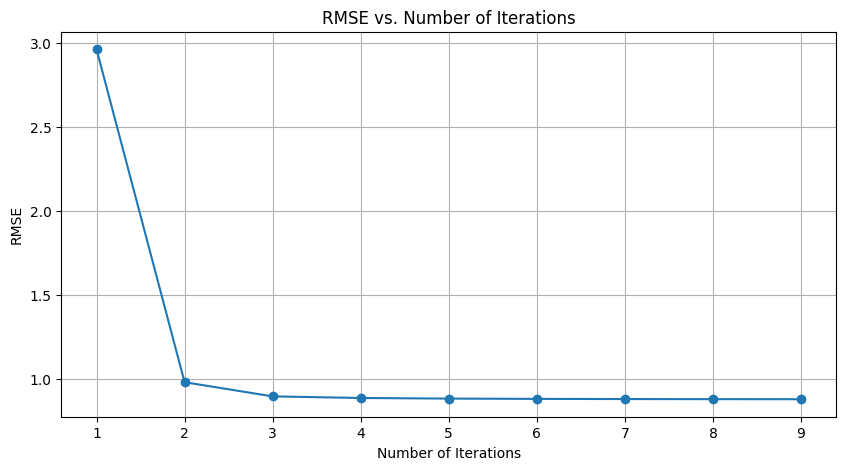

In [12]:
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

iter_range = range(1, 10)
rmse_values = []

for maxIter in iter_range:
    als = ALS(
        maxIter=maxIter,
        rank=best_rank,
        regParam=best_reg_param,
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",
        seed=42
    )
    model = als.fit(train)

    predictions = model.transform(test)
    rmse = evaluator.evaluate(predictions)
    rmse_values.append(rmse)
    print(f"RMSE for maxIter={maxIter}: {rmse}")

plt.figure(figsize=(10, 5))
plt.plot(iter_range, rmse_values, marker='o')
plt.title('RMSE vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## Make Recommendations

In [13]:
favorites = ["Toy Story"]
favorite_ids = movies.filter(movies.title.rlike("|".join([f".*{fav}.*" for fav in favorites]))) \
                        .select("movieId").distinct()

new_user_id = ratings.select(max("userId")).collect()[0][0] + 1
highest_rating = ratings.select(max("rating")).collect()[0][0]

new_user_data = favorite_ids.withColumn("userId", lit(new_user_id)) \
                            .withColumn("rating", lit(highest_rating)) \
                            .withColumn("timestamp", lit(0))

training_data = ratings.union(new_user_data)

als = ALS(
    maxIter=10,
    rank=best_rank,
    regParam=best_reg_param,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=42
)
model = als.fit(training_data)

user_recommendations = model.transform(training_data) \
                            .where(col("userId") != lit(new_user_id)) \
                            .sort("prediction", ascending=False) \
                            .limit(10) \
                            .join(movies, "movieId") \
                            .select("title") \
                            .collect()

print(f"Top 10 movie recommendations for user {new_user_id}:")
for i, movie in enumerate(user_recommendations):
    print(f"{i+1}: {movie.title}")





Top 10 movie recommendations for user 611:
1: Burnt by the Sun (Utomlyonnye solntsem) (1994)
2: Shawshank Redemption, The (1994)
3: Shawshank Redemption, The (1994)
4: Shawshank Redemption, The (1994)
5: Forrest Gump (1994)
6: Roman Holiday (1953)
7: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
8: River Runs Through It, A (1992)
9: Trial, The (Procès, Le) (1962)
10: Three Billboards Outside Ebbing, Missouri (2017)
